# Feature Engineering for NYC Taxi Trip Duration

This notebook contains the feature engineering steps for the NYC Taxi Trip Duration project.  
We will create new features from datetime, geospatial, and categorical variables, handle outliers, and prepare the dataset for modeling.

---

## **1. Imports & Setup**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline

#disable warnings
import warnings
warnings.filterwarnings('ignore')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Read data
df_train = pd.read_csv('/content/drive/MyDrive/Projects/NYC trip duration/split/train.csv')
df_val = pd.read_csv('/content/drive/MyDrive/Projects/NYC trip duration/split/val.csv')
df = pd.concat([df_train, df_val])

# Reset the index
df.reset_index(drop=True, inplace=True)

In [ ]:
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1040
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,827
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,614
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,867
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,4967


In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229319 entries, 0 to 1229318
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1229319 non-null  object 
 1   vendor_id           1229319 non-null  int64  
 2   pickup_datetime     1229319 non-null  object 
 3   passenger_count     1229319 non-null  int64  
 4   pickup_longitude    1229319 non-null  float64
 5   pickup_latitude     1229319 non-null  float64
 6   dropoff_longitude   1229319 non-null  float64
 7   dropoff_latitude    1229319 non-null  float64
 8   store_and_fwd_flag  1229319 non-null  object 
 9   trip_duration       1229319 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 93.8+ MB


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.229319e+06,1.229319e+06,1.229319e+06,1.229319e+06,1.229319e+06,1.229319e+06,1.229319e+06
mean,1.534912e+00,1.664531e+00,-7.397345e+01,4.075093e+01,-7.397340e+01,4.075182e+01,9.596917e+02
std,4.987798e-01,1.314509e+00,6.178003e-02,3.354454e-02,6.164072e-02,3.634104e-02,5.263573e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399185e+01,4.073737e+01,-7.399133e+01,4.073590e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398173e+01,4.075411e+01,-7.397976e+01,4.075453e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396735e+01,4.076836e+01,-7.396303e+01,4.076982e+01,1.075000e+03
max,2.000000e+00,8.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


## **2. Outlier handling**

In [ ]:

print(f"Data shape before early outlier removal: {df.shape}")

Data shape before early outlier removal: (1229319, 10)


In [ ]:
#Invalid values
df = df[df['passenger_count']>0]
#Extreme values
df = df[df["trip_duration"]>60]
df = df[df["trip_duration"] < df["trip_duration"].quantile(0.99)]
#print data shape after removing the outliers
print(f"Data shape after early outlier removal: {df.shape}")

Data shape after early outlier removal: (1209683, 10)


* **Passenger Count:** Removed trips with `0` passengers, since these are invalid.
* **Trip Duration:**

  * Dropped trips shorter than 60 seconds (likely errors).
  * Trimmed extreme values by keeping trips below the 99th percentile.
* **Next Steps:** Additional outlier filtering will be applied later after feature engineering, specifically for distance and speed (e.g., removing trips with unrealistic distances or speeds).


## **3. Datetime features**

In [ ]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df["hour"] = df["pickup_datetime"].dt.hour
df["weekday"] = df["pickup_datetime"].dt.dayofweek
df["month"] = df["pickup_datetime"].dt.month
df["is_weekend"] = df["weekday"].apply(lambda x: 1 if x > 4 else 0)
df["is_peak_hour"] = df["hour"].apply(lambda x: 1 if 7 <= x <= 9 or 16 <= x <= 19 else 0)

def time_of_day(hour):
    if 5 <= hour < 12: return "morning"
    elif 12 <= hour < 17: return "afternoon"
    elif 17 <= hour < 21: return "evening"
    else: return "night"

df["time_of_day"] = df["hour"].apply(time_of_day)




From `pickup_datetime`, we extracted model-ready components:  
- **pickup_hour** (0–23)  
- **pickup_dayofweek** (0=Mon … 6=Sun)  
- **pickup_month** (1–12)  
- **is_weekend** (binary flag)  
- **time_of_day** (Morning, Afternoon, Evening, Night — based on hour bins)  

These features capture temporal travel patterns (rush hours, weekdays vs weekends, seasonal effects) and replace the raw timestamp.  


## **4. Geospatial features**


In [ ]:
#Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

df["haversine_distance"] = df.apply(
    lambda row: haversine(row["pickup_latitude"], row["pickup_longitude"],
                          row["dropoff_latitude"], row["dropoff_longitude"]), axis=1
)
#Speed in Km/h
df["speed_km_h"] = df["haversine_distance"] / (df["trip_duration"] / 3600)


In [ ]:
#Handling outliers
df = df[df["haversine_distance"] > 0]
df = df[df["haversine_distance"] < df["haversine_distance"].quantile(0.99)]
df = df[df["speed_km_h"] < df["speed_km_h"].quantile(0.99)]
df = df[df['speed_km_h'] > 1]


- **Haversine Distance**  
  Calculated the direct distance (in km) between pickup and dropoff coordinates using the haversine formula.

- **Speed (km/h)**  
  Created a new feature by dividing distance by trip duration (in hours) to check for realistic trip speeds.

- **Outlier Handling**  
  - Removed trips with zero distance.  
  - Dropped trips above the 99th percentile for distance.  
  - Dropped trips above the 99th percentile for speed.  
  - Dropped trips with speeds lower than 1 km/h (likely data errors).  

These steps ensure that distance and speed features are reliable and consistent with real NYC driving conditions.
  


## **5. Feature interaction**

In [ ]:
#Distance-related interactions
df["distance_per_passenger"] = df["haversine_distance"] / df["passenger_count"]
df["distance_weekday"] = df["haversine_distance"] * df["weekday"]
df["distance_hour"] = df["haversine_distance"] * df["hour"]
df["distance_time_of_day"] = df["haversine_distance"] * df["time_of_day"].astype("category").cat.codes

#Speed-related interactions
df["speed_per_passenger"] = df["speed_km_h"] / df["passenger_count"]

#Temporal interactions
df["hour_weekday"] = df["hour"] * df["weekday"]
df["passenger_count_time_of_day"] = df["passenger_count"] * df["time_of_day"].astype("category").cat.codes



- **Distance-based interactions**  
  - `distance_per_passenger`: captures trip distance relative to the number of passengers.  
  - `distance_weekday`: highlights how trip distance varies across weekdays.  
  - `distance_hour`: captures the relationship between distance and hour of the day.  
  - `distance_time_of_day`: combines distance with binned time-of-day categories.

- **Speed-based interactions**  
  - `speed_per_passenger`: speed normalized by passenger count to capture efficiency differences.

- **Temporal interactions**  
  - `hour_weekday`: interaction between hour and weekday, reflecting weekly patterns.  
  - `passenger_count_time_of_day`: combines passenger count with time-of-day to explore demand patterns.


## **6. Encoding**

In [ ]:
# Binary encoding for store_and_fwd_flag
df["store_and_fwd_flag"] = df["store_and_fwd_flag"].map({"Y":1, "N":0})
df["vendor_id"] = df["vendor_id"].map({1: 0, 2: 1})
# One-Hot Encoding for vendor_id and time_of_day
df = pd.get_dummies(df, columns=["time_of_day"], drop_first=True)


- **Vendor ID:** Originally represented as `1` and `2`. Applied **binary encoding** since there are only two categories.  
- **Store-and-Forward Flag:** Same goes here its original values were `'Y'` / `'N'`. Encoded as `1` / `0` for modeling.  
- **Time of Day:** One hot encoded into 4 categories


## **7. Transformation**

In [ ]:
# Log-transform target to reduce skewness
df["trip_duration_transformed"] = np.log1p(df["trip_duration"])

## **8. Correlation and Importance review**

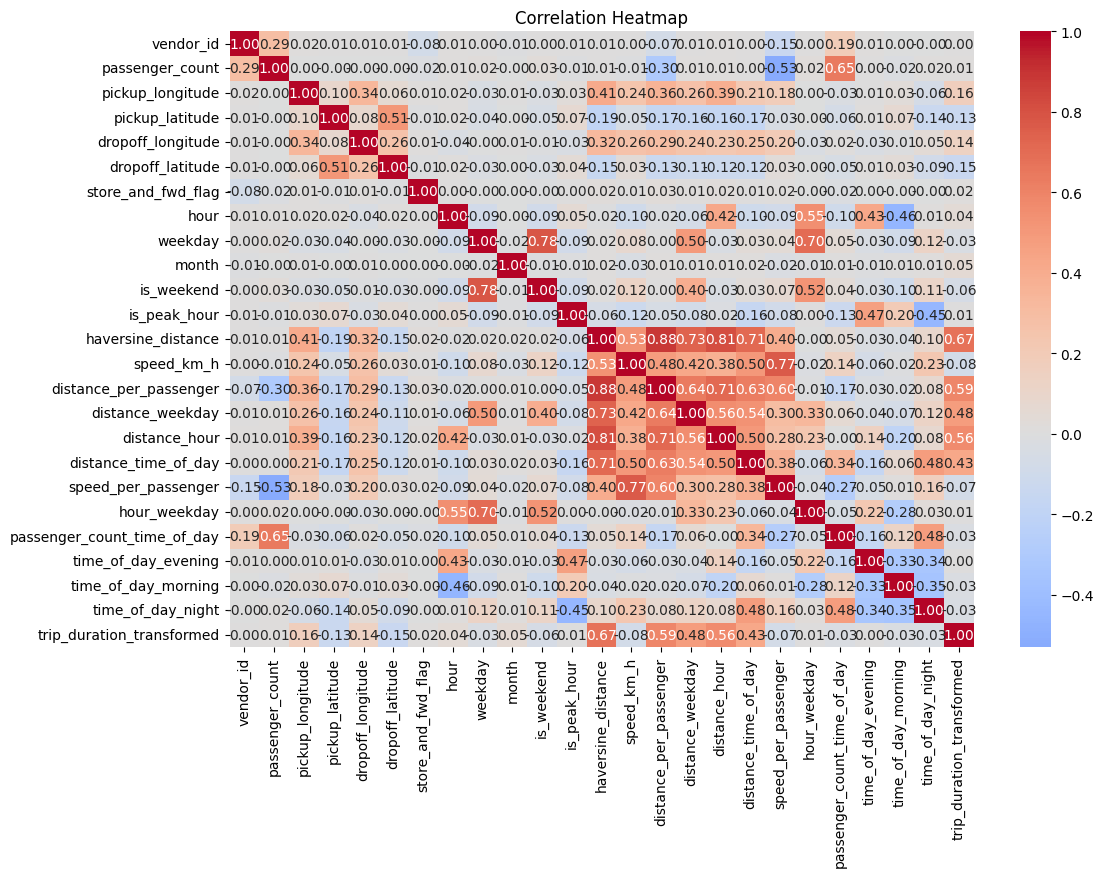

In [ ]:
#drop non-numeric and unused features in modeling
df.drop(columns=["pickup_datetime", "trip_duration" , "id"], inplace=True)

numeric_features = df.select_dtypes(include=np.number)
corr = numeric_features.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()